I find blockchain fascinating because it extends open source software development to open source + state. This seems to be a genuine/exciting innovation in computing paradigms; We don't just get to share code, we get to share a running computer, and anyone anywhere can use it in an open and permissionless manner. The seeds of this revolution arguably began with Bitcoin, so I became curious to drill into it in some detail to get an intuitive understanding of how it works. And in the spirit of "what I cannot create I do not understand", what better way to do this than implement it from scratch?

**In this Jupyter Notebook we are going to create, digitally sign, and broadcast a Bitcoin transaction in pure Python, from scratch, and with zero dependencies.** In the process we're going to learn quite a bit about how Bitcoin represents value. Let's get it.

#### Step 1: generating a crypto identity

First we want to generate a brand new cryptographic identity, which is just a private, public keypair. Bitcoin uses [Elliptic Curve Cryptography](https://en.wikipedia.org/wiki/Elliptic-curve_cryptography) instead of something more common like RSA to secure the transactions. I am not going to do a full introduction to ECC here because others have done a significantly better job, e.g. I found [Andrea Corbellini's blog post series](https://andrea.corbellini.name/2015/05/17/elliptic-curve-cryptography-a-gentle-introduction/) to be an exceptional resource. Here we are just going to write the code but to understand why it works mathematically you'd need to go through the series.

Okay so Bitcoin uses the [secp256k1](https://en.bitcoin.it/wiki/Secp256k1) curve. As a newbie to the area I found this part fascinating - there are entire libraries of different curves you can choose from which offer different pros/cons and properties. NIST publishes recommendations on which ones to use, but people prefer to use other curves (like secp256k1) that are less likely to have backdoors built into them. Anyway, an elliptic curve is a fairly low dimensional mathematical object and takes only 3 integers to define:

In [130]:
print("hello world")

hello world


In [131]:
from __future__ import annotations # PEP 563: Postponed Evaluation of Annotations
from dataclasses import dataclass # https://docs.python.org/3/library/dataclasses.html I like these a lot

@dataclass
class Curve:
    """
    Elliptic Curve over the field of integers modulo a prime.
    Points on the curve satisfy y^2 = x^3 + a*x + b (mod p).
    """
    p: int # the prime modulus of the finite field
    a: int
    b: int

# secp256k1 uses a = 0, b = 7, so we're dealing with the curve y^2 = x^3 + 7 (mod p)
bitcoin_curve = Curve(
    p = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEFFFFFC2F,
    a = 0x0000000000000000000000000000000000000000000000000000000000000000, # a = 0
    b = 0x0000000000000000000000000000000000000000000000000000000000000007, # b = 7
)


In addition to the actual curve we define a Generator point, which is just some fixed "starting point" on the curve's cycle, which is used to kick off the "random walk" around the curve. The generator is a publicly known and agreed upon constant:

In [132]:
@dataclass
class Point:
    """ An integer point (x,y) on a Curve """
    curve: Curve
    x: int
    y: int

G = Point(
    bitcoin_curve,
    x = 0x79BE667EF9DCBBAC55A06295CE870B07029BFCDB2DCE28D959F2815B16F81798,
    y = 0x483ada7726a3c4655da4fbfc0e1108a8fd17b448a68554199c47d08ffb10d4b8,
)

# we can verify that the generator point is indeed on the curve, i.e. y^2 = x^3 + 7 (mod p)
print("Generator IS on the curve: ", (G.y**2 - G.x**3 - 7) % bitcoin_curve.p == 0)

# some other totally random point will of course not be on the curve, _MOST_ likely
import random
random.seed(1337)
x = random.randrange(0, bitcoin_curve.p)
y = random.randrange(0, bitcoin_curve.p)
print("Totally random point is not: ", (y**2 - x**3 - 7) % bitcoin_curve.p == 0)

Generator IS on the curve:  True
Totally random point is not:  False


Finally, the order of the generating point G is known, and is effectively the "size of the set" we are working with in terms of the (x,y) integer tuples on the cycle around the curve. I like to organize this information into one more data structure I'll call Generator:

In [133]:
@dataclass
class Generator:
    """
    A generator over a curve: an initial point and the (pre-computed) order
    """
    G: Point     # a generator point on the curve
    n: int       # the order of the generating point, so 0*G = n*G = INF

bitcoin_gen = Generator(
    G = G,
    # the order of G is known and can be mathematically derived
    n = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEBAAEDCE6AF48A03BBFD25E8CD0364141,
)

Notice that we haven't really done anything so far, it's all just definition of some data structures, and filling them with the publicly known constants related to the elliptic curves used in Bitcoin. This is about to change, as we are ready to generate our private key. The private key (or "**secret key**" as I'll call it going forward) is simply a random integer that satisfies 1 <= key < n (recall n is the order of G):

In [134]:
# secret_key = random.randrange(1, bitcoin_gen.n) # this is how you _would_ do it
secret_key = int.from_bytes(b'Andrej is cool :P', 'big') # this is how I will do it for reproducibility
assert 1 <= secret_key < bitcoin_gen.n
print(secret_key)

22265090479312778178772228083027296664144


This is our secret key - it is a a pretty unassuming integer but anyone who knows it can control all of the funds you own on the Bitcoin blockchain, associated with it. In the simplest, most common vanilla use case of Bitcoin it is the single "password" that controls your account. Of course, in the exceedingly unlikely case that some other Andrej manually generated their secret key as I did above, the wallet associated with this secret key most likely has a balance of zero bitcoin :). If it didn't we'd be very lucky indeed.

We are now going to generate the **public key**, which is where things start to get interesting. The public key is the point on the curve that results from adding the generator point to itself secret_key times. i.e. we have: public_key = G + G + G + (secret key times) + G = secret_key * G. Notice that both the '+' (add) and the '\*' (times) symbol here is very special and slightly confusing. The secret key is an INTEGER, but the generator point G is an (x,y) tuple that is a Point on the Curve, resulting in an (x,y) tuple public key, again a Point on the Curve. This is where we have to actually define the Addition operator on an elliptic curve. It has a very specific definition and a geometric interpretation (see Andrea's post above), but the actual implementation is relatively simple:

In [135]:
INF = Point(None, None, None) # special point at "infinity", kind of like a zero

def extended_euclidean_algorithm(a, b):
    """
    Returns (gcd, x, y) s.t. a * x + b * y == gcd
    This function implements the extended Euclidean
    algorithm and runs in O(log b) in the worst case,
    taken from Wikipedia.
    """
    old_r, r = a, b
    old_s, s = 1, 0
    old_t, t = 0, 1
    while r != 0:
        quotient = old_r // r
        old_r, r = r, old_r - quotient * r
        old_s, s = s, old_s - quotient * s
        old_t, t = t, old_t - quotient * t
    return old_r, old_s, old_t

def inv(n, p):
    """ returns modular multiplicate inverse m s.t. (n * m) % p == 1 """
    gcd, x, y = extended_euclidean_algorithm(n, p) # pylint: disable=unused-variable
    return x % p

def elliptic_curve_addition(self, other: Point) -> Point:
    # handle special case of P + 0 = 0 + P = 0
    if self == INF:
        return other
    if other == INF:
        return self
    # handle special case of P + (-P) = 0
    if self.x == other.x and self.y != other.y:
        return INF
    # compute the "slope"
    if self.x == other.x: # (self.y = other.y is guaranteed too per above check)
        m = (3 * self.x**2 + self.curve.a) * inv(2 * self.y, self.curve.p)
    else:
        m = (self.y - other.y) * inv(self.x - other.x, self.curve.p)
    # compute the new point
    rx = (m**2 - self.x - other.x) % self.curve.p
    ry = (-(m*(rx - self.x) + self.y)) % self.curve.p
    return Point(self.curve, rx, ry)

Point.__add__ = elliptic_curve_addition # monkey patch addition into the Point class

I admit that it may look a bit scary and understanding and re-deriving the above took me a good half of a day. Most of the complexity comes from all of the math being done with modular arithmetic. So even simple operations like division '/' suddenly require algorithms such as the modular multiplicative inverse `inv`. But the important thing to note is that everything is just a bunch of adds/multiplies over the tuples (x,y) with some modulo p sprinkled everywhere in between. Let's take it for a spin by generating some trivial (private, public) keypairs:

In [136]:
# if our secret key was the interger 1, then our public key would just be G:
sk = 1
pk = G
print(f" secret key: {sk}\n public key: {(pk.x, pk.y)}")
print("Verify the public key is on the curve: ", (pk.y**2 - pk.x**3 - 7) % bitcoin_curve.p == 0)
# if it was 2, the public key is G + G:
sk = 2
pk = G + G
print(f" secret key: {sk}\n public key: {(pk.x, pk.y)}")
print("Verify the public key is on the curve: ", (pk.y**2 - pk.x**3 - 7) % bitcoin_curve.p == 0)
# etc.:
sk = 3
pk = G + G + G
print(f" secret key: {sk}\n public key: {(pk.x, pk.y)}")
print("Verify the public key is on the curve: ", (pk.y**2 - pk.x**3 - 7) % bitcoin_curve.p == 0)

 secret key: 1
 public key: (55066263022277343669578718895168534326250603453777594175500187360389116729240, 32670510020758816978083085130507043184471273380659243275938904335757337482424)
Verify the public key is on the curve:  True
 secret key: 2
 public key: (89565891926547004231252920425935692360644145829622209833684329913297188986597, 12158399299693830322967808612713398636155367887041628176798871954788371653930)
Verify the public key is on the curve:  True
 secret key: 3
 public key: (112711660439710606056748659173929673102114977341539408544630613555209775888121, 25583027980570883691656905877401976406448868254816295069919888960541586679410)
Verify the public key is on the curve:  True


Okay so we have some keypairs above, but we want the public key associated with our randomly generator secret key above. Using just the code above we'd have to add G to itself a very large number of times, because the secret key is a large integer. So the result would be correct but it would run very slow. Instead, let's implement the "double and add" algorithm to dramatically speed up the repeated addition. Again, see the post above for why it works, but here it is:

In [137]:
def double_and_add(self, k: int) -> Point:
    assert isinstance(k, int) and k >= 0
    result = INF
    append = self
    while k:
        if k & 1:
            result += append
        append += append
        k >>= 1
    return result

# monkey patch double and add into the Point class for convenience
Point.__rmul__ = double_and_add

# "verify" correctness
print(G == 1*G)
print(G + G == 2*G)
print(G + G + G == 3*G)

True
True
True


In [138]:
# efficiently calculate our actual public key!
public_key = secret_key * G
print(f"x: {public_key.x}\ny: {public_key.y}")
print("Verify the public key is on the curve: ", (public_key.y**2 - public_key.x**3 - 7) % bitcoin_curve.p == 0)

x: 83998262154709529558614902604110599582969848537757180553516367057821848015989
y: 37676469766173670826348691885774454391218658108212372128812329274086400588247
Verify the public key is on the curve:  True


In [139]:
test_curve = Curve(
    p = 0x43,
    a = 0x2, # a = 2
    b = 0x3, # b = 3
)

test_G = Point(
    test_curve,
    x = 0x2,
    y = 0x16,
)

# we can verify that the generator point is indeed on the curve, i.e. y^2 = x^3 + 2x+ 3 (mod p)
print("Generator IS on the curve: ", (test_G.y**2 - test_G.x**3 -test_curve.a*test_G.x - test_curve.b - 67) % test_curve.p == 0)

test_secret_key = 4

test_public_key = test_secret_key * test_G

print(f"x: {test_public_key.x}\ny: {test_public_key.y}")
print("Verify the public key is on the curve: ", (test_public_key.y**2 - test_public_key.x**3 - test_curve.a*test_public_key.x - test_curve.b - 67) % test_curve.p == 0)

r = 2

M=Point(test_curve, x=0x18,y=0x1a,)
print("M IS on the curve: ", (M.y**2 - M.x**3 -test_curve.a*M.x - test_curve.b - 67) % test_curve.p == 0)

C1 = r * test_G
C2 = M + r*test_public_key
print("C1 is: ", C1, "C2 is: ", C2 )

def elliptic_curve_subtraction(self, other: Point) -> Point:
    result = Point(test_curve,    x = 0x0,    y = 0x0)
    self.y = self.y *(-1)
    result= elliptic_curve_addition(self,other)
    result.y = result.y * (-1) %test_curve.p
    return result

Point.__sub__ = elliptic_curve_subtraction

print("test: ", C2-test_secret_key*C1)


Generator IS on the curve:  True
x: 13
y: 45
Verify the public key is on the curve:  True
M IS on the curve:  True
C1 is:  Point(curve=Curve(p=67, a=2, b=3), x=35, y=1) C2 is:  Point(curve=Curve(p=67, a=2, b=3), x=21, y=44)
test:  Point(curve=Curve(p=67, a=2, b=3), x=24, y=26)


With the private/public key pair we've now generated our crypto identity. Now it is time to deverive the associated Bitcoin wallet address. The wallet address is not just the public key itself, but it can be deterministically derived from it and has a few extra goodies (such as an embedded checksum). Before we can generate the address though we need to define some hash functions. Bitcoin uses the ubiquitous SHA-256 and also RIPEMD-160. We could just plug and play use the implementations in Python's `hashlib`, but this is supposed to be a zero-dependency implementation, so `import hashlib` is cheating. So first here is the SHA256 implementation I wrote in pure Python following the (relatively readable) NIST [FIPS PUB 180-4](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.180-4.pdf) doc:

In [140]:
def gen_sha256_with_variable_scope_protector_to_not_pollute_global_namespace():
    
    """
    SHA256 implementation.
    
    Follows the FIPS PUB 180-4 description for calculating SHA-256 hash function
    https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.180-4.pdf

    Noone in their right mind should use this for any serious reason. This was written
    purely for educational purposes.
    """

    import math
    from itertools import count, islice

    # -----------------------------------------------------------------------------
    # SHA-256 Functions, defined in Section 4

    def rotr(x, n, size=32):
        return (x >> n) | (x << size - n) & (2**size - 1)

    def shr(x, n):
        return x >> n

    def sig0(x):
        return rotr(x, 7) ^ rotr(x, 18) ^ shr(x, 3)

    def sig1(x):
        return rotr(x, 17) ^ rotr(x, 19) ^ shr(x, 10)

    def capsig0(x):
        return rotr(x, 2) ^ rotr(x, 13) ^ rotr(x, 22)

    def capsig1(x):
        return rotr(x, 6) ^ rotr(x, 11) ^ rotr(x, 25)

    def ch(x, y, z):
        return (x & y)^ (~x & z)

    def maj(x, y, z):
        return (x & y) ^ (x & z) ^ (y & z)

    def b2i(b):
        return int.from_bytes(b, 'big')

    def i2b(i):
        return i.to_bytes(4, 'big')

    # -----------------------------------------------------------------------------
    # SHA-256 Constants

    def is_prime(n):
        return not any(f for f in range(2,int(math.sqrt(n))+1) if n%f == 0)

    def first_n_primes(n):
        return islice(filter(is_prime, count(start=2)), n)

    def frac_bin(f, n=32):
        """ return the first n bits of fractional part of float f """
        f -= math.floor(f) # get only the fractional part
        f *= 2**n # shift left
        f = int(f) # truncate the rest of the fractional content
        return f

    def genK():
        """
        Follows Section 4.2.2 to generate K

        The first 32 bits of the fractional parts of the cube roots of the first
        64 prime numbers:

        428a2f98 71374491 b5c0fbcf e9b5dba5 3956c25b 59f111f1 923f82a4 ab1c5ed5
        d807aa98 12835b01 243185be 550c7dc3 72be5d74 80deb1fe 9bdc06a7 c19bf174
        e49b69c1 efbe4786 0fc19dc6 240ca1cc 2de92c6f 4a7484aa 5cb0a9dc 76f988da
        983e5152 a831c66d b00327c8 bf597fc7 c6e00bf3 d5a79147 06ca6351 14292967
        27b70a85 2e1b2138 4d2c6dfc 53380d13 650a7354 766a0abb 81c2c92e 92722c85
        a2bfe8a1 a81a664b c24b8b70 c76c51a3 d192e819 d6990624 f40e3585 106aa070
        19a4c116 1e376c08 2748774c 34b0bcb5 391c0cb3 4ed8aa4a 5b9cca4f 682e6ff3
        748f82ee 78a5636f 84c87814 8cc70208 90befffa a4506ceb bef9a3f7 c67178f2
        """
        return [frac_bin(p ** (1/3.0)) for p in first_n_primes(64)]

    def genH():
        """
        Follows Section 5.3.3 to generate the initial hash value H^0

        The first 32 bits of the fractional parts of the square roots of
        the first 8 prime numbers.

        6a09e667 bb67ae85 3c6ef372 a54ff53a 9b05688c 510e527f 1f83d9ab 5be0cd19
        """
        return [frac_bin(p ** (1/2.0)) for p in first_n_primes(8)]

    # -----------------------------------------------------------------------------

    def pad(b):
        """ Follows Section 5.1: Padding the message """
        b = bytearray(b) # convert to a mutable equivalent
        l = len(b) * 8 # note: len returns number of bytes not bits

        # append but "1" to the end of the message
        b.append(0b10000000) # appending 10000000 in binary (=128 in decimal)

        # follow by k zero bits, where k is the smallest non-negative solution to
        # l + 1 + k = 448 mod 512
        # i.e. pad with zeros until we reach 448 (mod 512)
        while (len(b)*8) % 512 != 448:
            b.append(0x00)

        # the last 64-bit block is the length l of the original message
        # expressed in binary (big endian)
        b.extend(l.to_bytes(8, 'big'))

        return b

    def sha256(b: bytes) -> bytes:

        # Section 4.2
        K = genK()

        # Section 5: Preprocessing
        # Section 5.1: Pad the message
        b = pad(b)
        # Section 5.2: Separate the message into blocks of 512 bits (64 bytes)
        blocks = [b[i:i+64] for i in range(0, len(b), 64)]

        # for each message block M^1 ... M^N
        H = genH() # Section 5.3

        # Section 6
        for M in blocks: # each block is a 64-entry array of 8-bit bytes

            # 1. Prepare the message schedule, a 64-entry array of 32-bit words
            W = []
            for t in range(64):
                if t <= 15:
                    # the first 16 words are just a copy of the block
                    W.append(bytes(M[t*4:t*4+4]))
                else:
                    term1 = sig1(b2i(W[t-2]))
                    term2 = b2i(W[t-7])
                    term3 = sig0(b2i(W[t-15]))
                    term4 = b2i(W[t-16])
                    total = (term1 + term2 + term3 + term4) % 2**32
                    W.append(i2b(total))

            # 2. Initialize the 8 working variables a,b,c,d,e,f,g,h with prev hash value
            a, b, c, d, e, f, g, h = H

            # 3.
            for t in range(64):
                T1 = (h + capsig1(e) + ch(e, f, g) + K[t] + b2i(W[t])) % 2**32
                T2 = (capsig0(a) + maj(a, b, c)) % 2**32
                h = g
                g = f
                f = e
                e = (d + T1) % 2**32
                d = c
                c = b
                b = a
                a = (T1 + T2) % 2**32

            # 4. Compute the i-th intermediate hash value H^i
            delta = [a, b, c, d, e, f, g, h]
            H = [(i1 + i2) % 2**32 for i1, i2 in zip(H, delta)]

        return b''.join(i2b(i) for i in H)
    
    return sha256

sha256 = gen_sha256_with_variable_scope_protector_to_not_pollute_global_namespace()
print("verify empty hash:", sha256(b'').hex()) # should be e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855
print(sha256(b'here is a random bytes message, cool right?').hex())
print(sha256(0).hex())
print("number of bytes in a sha256 digest: ", len(sha256(b'')))
print("number of bytes in a sha256 digest: ", len(sha256(b'helloworld')),sha256(b'helloworld').hex())
print("number of bytes in a sha256 digest: ", len(sha256(b'hilloworld')),sha256(b'hilloworld').hex())



verify empty hash: e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855
69b9779edaa573a509999cbae415d3408c30544bad09727a1d64eff353c95b89
e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855
number of bytes in a sha256 digest:  32
number of bytes in a sha256 digest:  32 936a185caaa266bb9cbe981e9e05cb78cd732b0b3280eb944412bb6f8f8f07af
number of bytes in a sha256 digest:  32 33de617f1031e1bd79f81180b7045ce1de4d395541f0b143d885e2a0423df2c2


In [141]:
import hashlib

def mine_block(difficulty): 
        """ 
        Mines the block using the Proof-of-Work algorithm  
        with the given difficulty level. 
        """
        data = "hello world"
        nonce = 0
        sha = hashlib.sha256() 
        sha.update(str(data).encode('utf-8') + str(nonce).encode('utf-8')) 
        hash = sha.hexdigest() 
        while hash[0:difficulty] != "0" * difficulty: 
            nonce += 1
            sha.update(str(data).encode('utf-8') + str(nonce).encode('utf-8')) 
            hash = sha.hexdigest()
            print("Block mining:", nonce, hash) 
  
        print("Block mined:", nonce, hash) 
    
mine_block(2)

    

Block mining: 1 866e5b053e2226f363a7c70a103317298b979e59587ae7986dcdf97369bc287f
Block mining: 2 18b49d578828cabd257bcea7c151c7d338c6d5589745a85c4cdcff1a20dc718d
Block mining: 3 09c25401f038b75e0c29266a455460357e038bc4778754715d4cb19d6e1a86c0
Block mining: 4 d27ff89ab241d6db32b24933a7688ab3cc110de4c607eeac601f587e6b740a33
Block mining: 5 654e07865573ff9fa378391fad2340f85bd633076aa0a719624ef88d2869a934
Block mining: 6 1986761dac67e271801448a4d16e41bcf500383db797fc8698af5e950be9cd79
Block mining: 7 f20730321ab0fd3454c6ed312b7e8ca5e1e1d6330bc4a5d4bcd0fa7c5c86f027
Block mining: 8 357c783da7206ac29dec2d0d9136916e431f62a00f48f17b836f0cacd09a03d4
Block mining: 9 e8f6d0ced2889ab33d4a9a7492029496420f942725c971b2a0b3559b63281667
Block mining: 10 f8e5b2e3470d2eb9303a603dcb1307dac98d35dc98e1616d6e37b62e38f2ed4d
Block mining: 11 66288ac07b23ee9dafbd273d0867379cba37ac02f930cdb5337ba3b8f72ee2dc
Block mining: 12 9388b3630a7cf97feab9fea40edf7a808c97bda348d1612c7a225e8f2a8a89ca
Block mining: 13 bc291fce

Okay the reason I wanted to implement this from scratch and paste it here is that I want you to note that again there is nothing too scary going on inside. SHA256 takes some bytes message that is to be hashed, it first pads the message, then breaks it up into chunks, and passes these chunks into what can best be described as a fancy "bit mixer", defined in section 3, that contains a number of bit shifts and binary operations orchestrated in a way that is frankly beyond me, but that results in the beautiful properties that SHA256 offers. In particular, it creates a fixed-sized, random-looking short digest of any variably-sized original message s.t. the scrambling is not invertible and also it is basically computationally impossible to construct a different message that hashes to any given digest. 

Bitcoin uses SHA256 everywhere to create hashes, and of course it is the core element in Bitcoin's Proof of Work, where the goal is to modify the block of transactions until the whole thing hashes to a sufficiently low number (when the bytes of the digest are interpreted as a number). Which, due to the nice properties of SHA256, can only be done via brute force search. So all of the ASICs designed for efficient mining are just incredibly optimized close-to-the-metal implementations of exactly the above code.

Anyway before we can generate our address we also need the RIPEMD160 hash function, which I found on the internet and shortened and cleaned up:

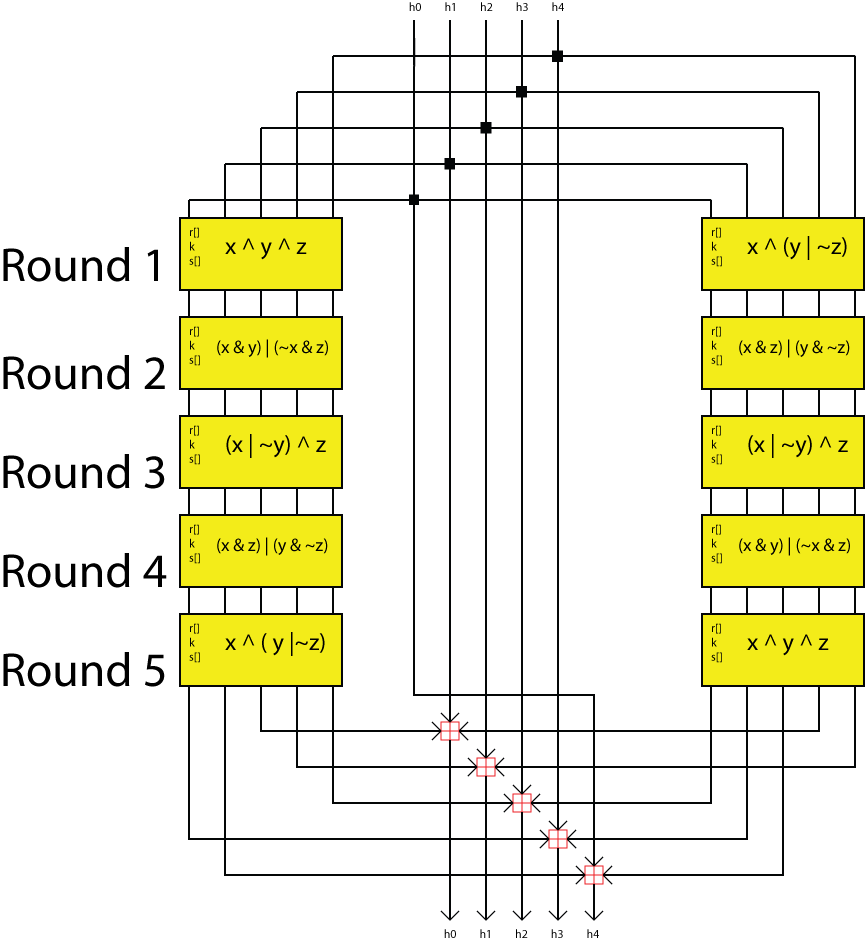

In [142]:
def gen_ripemd160_with_variable_scope_protector_to_not_pollute_global_namespace():

    import sys
    import struct

    # -----------------------------------------------------------------------------
    # public interface

    def ripemd160(b: bytes) -> bytes:
        """ simple wrapper for a simpler API to this hash function, just bytes to bytes """
        ctx = RMDContext()
        RMD160Update(ctx, b, len(b)) #如果输入很长，处理前面的块
        digest = RMD160Final(ctx)    #最后的一块或两块
        return digest

    # -----------------------------------------------------------------------------

    class RMDContext:
        def __init__(self):
            self.state = [0x67452301, 0xEFCDAB89, 0x98BADCFE, 0x10325476, 0xC3D2E1F0] # uint32
            self.count = 0 # uint64
            self.buffer = [0]*64 # uchar

    def RMD160Update(ctx, inp, inplen):   #准备数据，接下来进行bit-mixing
        have = int((ctx.count // 8) % 64)  #最后一块
        inplen = int(inplen)
        need = 64 - have
        ctx.count += 8 * inplen  #字节为单位，改成bit为单位，准备处理最后一块
        off = 0
        if inplen >= need: #长度大于64，准备512bit
            if have:      #处理final的情况
                for i in range(need):
                    ctx.buffer[have+i] = inp[i]
                RMD160Transform(ctx.state, ctx.buffer)
                off = need
                have = 0
            while off + 64 <= inplen:  #以512为单位，循环处理
                RMD160Transform(ctx.state, inp[off:])
                off += 64
        if off < inplen: #不是512的整数倍
            for i in range(inplen - off):
                ctx.buffer[have+i] = inp[off+i]

    def RMD160Final(ctx):
        size = struct.pack("<Q", ctx.count)   #长度，最后8字节
        #< character indicates little-endian byte order, which is the least significant byte first. 
        #Q character represents a 64-bit unsigned integer (QUInt64 in C struct terminology)
        padlen = 64 - ((ctx.count // 8) % 64)  #计算出需要填充的字节
        if padlen < 1 + 8:                     #输入长度+0x10需要的空间
            padlen += 64                      #需要填充一整块
        RMD160Update(ctx, PADDING, padlen-8)
        RMD160Update(ctx, size, 8)
        return struct.pack("<5L", *ctx.state)

    # -----------------------------------------------------------------------------

    K0 = 0x00000000
    K1 = 0x5A827999
    K2 = 0x6ED9EBA1
    K3 = 0x8F1BBCDC
    K4 = 0xA953FD4E
    KK0 = 0x50A28BE6
    KK1 = 0x5C4DD124
    KK2 = 0x6D703EF3
    KK3 = 0x7A6D76E9
    KK4 = 0x00000000

    PADDING = [0x80] + [0]*63

    def ROL(n, x):
        return ((x << n) & 0xffffffff) | (x >> (32 - n))

    def F0(x, y, z):
        return x ^ y ^ z

    def F1(x, y, z):
        return (x & y) | (((~x) % 0x100000000) & z)

    def F2(x, y, z):
        return (x | ((~y) % 0x100000000)) ^ z

    def F3(x, y, z):
        return (x & z) | (((~z) % 0x100000000) & y)

    def F4(x, y, z):
        return x ^ (y | ((~z) % 0x100000000))

    def R(a, b, c, d, e, Fj, Kj, sj, rj, X):
        a = ROL(sj, (a + Fj(b, c, d) + X[rj] + Kj) % 0x100000000) + e
        c = ROL(10, c)
        return a % 0x100000000, c

    def RMD160Transform(state, block): #uint32 state[5], uchar block[64]

        x = [0]*16
        assert sys.byteorder == 'little', "Only little endian is supported atm for RIPEMD160"
        x = struct.unpack('<16L', bytes(block[0:64]))

        a = state[0]
        b = state[1]
        c = state[2]
        d = state[3]
        e = state[4]

        #/* Round 1 */
        a, c = R(a, b, c, d, e, F0, K0, 11,  0, x)
        e, b = R(e, a, b, c, d, F0, K0, 14,  1, x)
        d, a = R(d, e, a, b, c, F0, K0, 15,  2, x)
        c, e = R(c, d, e, a, b, F0, K0, 12,  3, x)
        b, d = R(b, c, d, e, a, F0, K0,  5,  4, x)
        a, c = R(a, b, c, d, e, F0, K0,  8,  5, x)
        e, b = R(e, a, b, c, d, F0, K0,  7,  6, x)
        d, a = R(d, e, a, b, c, F0, K0,  9,  7, x)
        c, e = R(c, d, e, a, b, F0, K0, 11,  8, x)
        b, d = R(b, c, d, e, a, F0, K0, 13,  9, x)
        a, c = R(a, b, c, d, e, F0, K0, 14, 10, x)
        e, b = R(e, a, b, c, d, F0, K0, 15, 11, x)
        d, a = R(d, e, a, b, c, F0, K0,  6, 12, x)
        c, e = R(c, d, e, a, b, F0, K0,  7, 13, x)
        b, d = R(b, c, d, e, a, F0, K0,  9, 14, x)
        a, c = R(a, b, c, d, e, F0, K0,  8, 15, x) #/* #15 */
        #/* Round 2 */
        e, b = R(e, a, b, c, d, F1, K1,  7,  7, x)
        d, a = R(d, e, a, b, c, F1, K1,  6,  4, x)
        c, e = R(c, d, e, a, b, F1, K1,  8, 13, x)
        b, d = R(b, c, d, e, a, F1, K1, 13,  1, x)
        a, c = R(a, b, c, d, e, F1, K1, 11, 10, x)
        e, b = R(e, a, b, c, d, F1, K1,  9,  6, x)
        d, a = R(d, e, a, b, c, F1, K1,  7, 15, x)
        c, e = R(c, d, e, a, b, F1, K1, 15,  3, x)
        b, d = R(b, c, d, e, a, F1, K1,  7, 12, x)
        a, c = R(a, b, c, d, e, F1, K1, 12,  0, x)
        e, b = R(e, a, b, c, d, F1, K1, 15,  9, x)
        d, a = R(d, e, a, b, c, F1, K1,  9,  5, x)
        c, e = R(c, d, e, a, b, F1, K1, 11,  2, x)
        b, d = R(b, c, d, e, a, F1, K1,  7, 14, x)
        a, c = R(a, b, c, d, e, F1, K1, 13, 11, x)
        e, b = R(e, a, b, c, d, F1, K1, 12,  8, x) #/* #31 */
        #/* Round 3 */
        d, a = R(d, e, a, b, c, F2, K2, 11,  3, x)
        c, e = R(c, d, e, a, b, F2, K2, 13, 10, x)
        b, d = R(b, c, d, e, a, F2, K2,  6, 14, x)
        a, c = R(a, b, c, d, e, F2, K2,  7,  4, x)
        e, b = R(e, a, b, c, d, F2, K2, 14,  9, x)
        d, a = R(d, e, a, b, c, F2, K2,  9, 15, x)
        c, e = R(c, d, e, a, b, F2, K2, 13,  8, x)
        b, d = R(b, c, d, e, a, F2, K2, 15,  1, x)
        a, c = R(a, b, c, d, e, F2, K2, 14,  2, x)
        e, b = R(e, a, b, c, d, F2, K2,  8,  7, x)
        d, a = R(d, e, a, b, c, F2, K2, 13,  0, x)
        c, e = R(c, d, e, a, b, F2, K2,  6,  6, x)
        b, d = R(b, c, d, e, a, F2, K2,  5, 13, x)
        a, c = R(a, b, c, d, e, F2, K2, 12, 11, x)
        e, b = R(e, a, b, c, d, F2, K2,  7,  5, x)
        d, a = R(d, e, a, b, c, F2, K2,  5, 12, x) #/* #47 */
        #/* Round 4 */
        c, e = R(c, d, e, a, b, F3, K3, 11,  1, x)
        b, d = R(b, c, d, e, a, F3, K3, 12,  9, x)
        a, c = R(a, b, c, d, e, F3, K3, 14, 11, x)
        e, b = R(e, a, b, c, d, F3, K3, 15, 10, x)
        d, a = R(d, e, a, b, c, F3, K3, 14,  0, x)
        c, e = R(c, d, e, a, b, F3, K3, 15,  8, x)
        b, d = R(b, c, d, e, a, F3, K3,  9, 12, x)
        a, c = R(a, b, c, d, e, F3, K3,  8,  4, x)
        e, b = R(e, a, b, c, d, F3, K3,  9, 13, x)
        d, a = R(d, e, a, b, c, F3, K3, 14,  3, x)
        c, e = R(c, d, e, a, b, F3, K3,  5,  7, x)
        b, d = R(b, c, d, e, a, F3, K3,  6, 15, x)
        a, c = R(a, b, c, d, e, F3, K3,  8, 14, x)
        e, b = R(e, a, b, c, d, F3, K3,  6,  5, x)
        d, a = R(d, e, a, b, c, F3, K3,  5,  6, x)
        c, e = R(c, d, e, a, b, F3, K3, 12,  2, x) #/* #63 */
        #/* Round 5 */
        b, d = R(b, c, d, e, a, F4, K4,  9,  4, x)
        a, c = R(a, b, c, d, e, F4, K4, 15,  0, x)
        e, b = R(e, a, b, c, d, F4, K4,  5,  5, x)
        d, a = R(d, e, a, b, c, F4, K4, 11,  9, x)
        c, e = R(c, d, e, a, b, F4, K4,  6,  7, x)
        b, d = R(b, c, d, e, a, F4, K4,  8, 12, x)
        a, c = R(a, b, c, d, e, F4, K4, 13,  2, x)
        e, b = R(e, a, b, c, d, F4, K4, 12, 10, x)
        d, a = R(d, e, a, b, c, F4, K4,  5, 14, x)
        c, e = R(c, d, e, a, b, F4, K4, 12,  1, x)
        b, d = R(b, c, d, e, a, F4, K4, 13,  3, x)
        a, c = R(a, b, c, d, e, F4, K4, 14,  8, x)
        e, b = R(e, a, b, c, d, F4, K4, 11, 11, x)
        d, a = R(d, e, a, b, c, F4, K4,  8,  6, x)
        c, e = R(c, d, e, a, b, F4, K4,  5, 15, x)
        b, d = R(b, c, d, e, a, F4, K4,  6, 13, x) #/* #79 */

        aa = a
        bb = b
        cc = c
        dd = d
        ee = e

        a = state[0]
        b = state[1]
        c = state[2]
        d = state[3]
        e = state[4]

        #/* Parallel round 1 */
        a, c = R(a, b, c, d, e, F4, KK0,  8,  5, x)
        e, b = R(e, a, b, c, d, F4, KK0,  9, 14, x)
        d, a = R(d, e, a, b, c, F4, KK0,  9,  7, x)
        c, e = R(c, d, e, a, b, F4, KK0, 11,  0, x)
        b, d = R(b, c, d, e, a, F4, KK0, 13,  9, x)
        a, c = R(a, b, c, d, e, F4, KK0, 15,  2, x)
        e, b = R(e, a, b, c, d, F4, KK0, 15, 11, x)
        d, a = R(d, e, a, b, c, F4, KK0,  5,  4, x)
        c, e = R(c, d, e, a, b, F4, KK0,  7, 13, x)
        b, d = R(b, c, d, e, a, F4, KK0,  7,  6, x)
        a, c = R(a, b, c, d, e, F4, KK0,  8, 15, x)
        e, b = R(e, a, b, c, d, F4, KK0, 11,  8, x)
        d, a = R(d, e, a, b, c, F4, KK0, 14,  1, x)
        c, e = R(c, d, e, a, b, F4, KK0, 14, 10, x)
        b, d = R(b, c, d, e, a, F4, KK0, 12,  3, x)
        a, c = R(a, b, c, d, e, F4, KK0,  6, 12, x) #/* #15 */
        #/* Parallel round 2 */
        e, b = R(e, a, b, c, d, F3, KK1,  9,  6, x)
        d, a = R(d, e, a, b, c, F3, KK1, 13, 11, x)
        c, e = R(c, d, e, a, b, F3, KK1, 15,  3, x)
        b, d = R(b, c, d, e, a, F3, KK1,  7,  7, x)
        a, c = R(a, b, c, d, e, F3, KK1, 12,  0, x)
        e, b = R(e, a, b, c, d, F3, KK1,  8, 13, x)
        d, a = R(d, e, a, b, c, F3, KK1,  9,  5, x)
        c, e = R(c, d, e, a, b, F3, KK1, 11, 10, x)
        b, d = R(b, c, d, e, a, F3, KK1,  7, 14, x)
        a, c = R(a, b, c, d, e, F3, KK1,  7, 15, x)
        e, b = R(e, a, b, c, d, F3, KK1, 12,  8, x)
        d, a = R(d, e, a, b, c, F3, KK1,  7, 12, x)
        c, e = R(c, d, e, a, b, F3, KK1,  6,  4, x)
        b, d = R(b, c, d, e, a, F3, KK1, 15,  9, x)
        a, c = R(a, b, c, d, e, F3, KK1, 13,  1, x)
        e, b = R(e, a, b, c, d, F3, KK1, 11,  2, x) #/* #31 */
        #/* Parallel round 3 */
        d, a = R(d, e, a, b, c, F2, KK2,  9, 15, x)
        c, e = R(c, d, e, a, b, F2, KK2,  7,  5, x)
        b, d = R(b, c, d, e, a, F2, KK2, 15,  1, x)
        a, c = R(a, b, c, d, e, F2, KK2, 11,  3, x)
        e, b = R(e, a, b, c, d, F2, KK2,  8,  7, x)
        d, a = R(d, e, a, b, c, F2, KK2,  6, 14, x)
        c, e = R(c, d, e, a, b, F2, KK2,  6,  6, x)
        b, d = R(b, c, d, e, a, F2, KK2, 14,  9, x)
        a, c = R(a, b, c, d, e, F2, KK2, 12, 11, x)
        e, b = R(e, a, b, c, d, F2, KK2, 13,  8, x)
        d, a = R(d, e, a, b, c, F2, KK2,  5, 12, x)
        c, e = R(c, d, e, a, b, F2, KK2, 14,  2, x)
        b, d = R(b, c, d, e, a, F2, KK2, 13, 10, x)
        a, c = R(a, b, c, d, e, F2, KK2, 13,  0, x)
        e, b = R(e, a, b, c, d, F2, KK2,  7,  4, x)
        d, a = R(d, e, a, b, c, F2, KK2,  5, 13, x) #/* #47 */
        #/* Parallel round 4 */
        c, e = R(c, d, e, a, b, F1, KK3, 15,  8, x)
        b, d = R(b, c, d, e, a, F1, KK3,  5,  6, x)
        a, c = R(a, b, c, d, e, F1, KK3,  8,  4, x)
        e, b = R(e, a, b, c, d, F1, KK3, 11,  1, x)
        d, a = R(d, e, a, b, c, F1, KK3, 14,  3, x)
        c, e = R(c, d, e, a, b, F1, KK3, 14, 11, x)
        b, d = R(b, c, d, e, a, F1, KK3,  6, 15, x)
        a, c = R(a, b, c, d, e, F1, KK3, 14,  0, x)
        e, b = R(e, a, b, c, d, F1, KK3,  6,  5, x)
        d, a = R(d, e, a, b, c, F1, KK3,  9, 12, x)
        c, e = R(c, d, e, a, b, F1, KK3, 12,  2, x)
        b, d = R(b, c, d, e, a, F1, KK3,  9, 13, x)
        a, c = R(a, b, c, d, e, F1, KK3, 12,  9, x)
        e, b = R(e, a, b, c, d, F1, KK3,  5,  7, x)
        d, a = R(d, e, a, b, c, F1, KK3, 15, 10, x)
        c, e = R(c, d, e, a, b, F1, KK3,  8, 14, x) #/* #63 */
        #/* Parallel round 5 */
        b, d = R(b, c, d, e, a, F0, KK4,  8, 12, x)
        a, c = R(a, b, c, d, e, F0, KK4,  5, 15, x)
        e, b = R(e, a, b, c, d, F0, KK4, 12, 10, x)
        d, a = R(d, e, a, b, c, F0, KK4,  9,  4, x)
        c, e = R(c, d, e, a, b, F0, KK4, 12,  1, x)
        b, d = R(b, c, d, e, a, F0, KK4,  5,  5, x)
        a, c = R(a, b, c, d, e, F0, KK4, 14,  8, x)
        e, b = R(e, a, b, c, d, F0, KK4,  6,  7, x)
        d, a = R(d, e, a, b, c, F0, KK4,  8,  6, x)
        c, e = R(c, d, e, a, b, F0, KK4, 13,  2, x)
        b, d = R(b, c, d, e, a, F0, KK4,  6, 13, x)
        a, c = R(a, b, c, d, e, F0, KK4,  5, 14, x)
        e, b = R(e, a, b, c, d, F0, KK4, 15,  0, x)
        d, a = R(d, e, a, b, c, F0, KK4, 13,  3, x)
        c, e = R(c, d, e, a, b, F0, KK4, 11,  9, x)
        b, d = R(b, c, d, e, a, F0, KK4, 11, 11, x) #/* #79 */

        t = (state[1] + cc + d) % 0x100000000
        state[1] = (state[2] + dd + e) % 0x100000000
        state[2] = (state[3] + ee + a) % 0x100000000
        state[3] = (state[4] + aa + b) % 0x100000000
        state[4] = (state[0] + bb + c) % 0x100000000
        state[0] = t % 0x100000000
    
    return ripemd160
    
ripemd160 = gen_ripemd160_with_variable_scope_protector_to_not_pollute_global_namespace()
print(ripemd160(b'hello this is a test').hex())
print("number of bytes in a RIPEMD-160 digest: ", len(ripemd160(b'')))

f51960af7dd4813a587ab26388ddab3b28d1f7b4
number of bytes in a RIPEMD-160 digest:  20


As with SHA256 above, again we see a "bit scrambler" of a lot of binary ops. Pretty cool. 

Okay we are finally ready to get our Bitcoin address. We are going to make this nice by creating a subclass of `Point` called `PublicKey` which is, again, just a Point on the Curve but now has some additional semantics and interpretation of a Bitcoin public key, together with some methods of encoding/decoding the key into bytes for communication in the Bitcoin protocol.


In [143]:

class PublicKey(Point):
    """
    The public key is just a Point on a Curve, but has some additional specific
    encoding / decoding functionality that this class implements.
    """

    @classmethod #cls: This is a reference to the class itself. It is a convention in Python 
    #to use cls as the name of the first parameter for class methods to indicate that it is a class reference.
    #the Point instance is being transformed or converted into an instance of another class, PublicKey
    def from_point(cls, pt: Point):
        """ promote a Point to be a PublicKey """
        return cls(pt.curve, pt.x, pt.y)

    def encode(self, compressed, hash160=False):
        """ return the SEC bytes encoding of the public key Point """
        # calculate the bytes
        if compressed:  #压缩版仅包括x，因为关于x轴对称，因此需指明是基数还是偶数
            # (x,y) is very redundant. Because y^2 = x^3 + 7,
            # we can just encode x, and then y = +/- sqrt(x^3 + 7),
            # so we need one more bit to encode whether it was the + or the -
            # but because this is modular arithmetic there is no +/-, instead
            # it can be shown that one y will always be even and the other odd.
            prefix = b'\x02' if self.y % 2 == 0 else b'\x03'   
            pkb = prefix + self.x.to_bytes(32, 'big')
        else:
            pkb = b'\x04' + self.x.to_bytes(32, 'big') + self.y.to_bytes(32, 'big')
        # hash if desired
        return ripemd160(sha256(pkb)) if hash160 else pkb

    def address(self, net: str, compressed: bool) -> str:
        """ return the associated bitcoin address for this public key as string """
        # encode the public key into bytes and hash to get the payload
        pkb_hash = self.encode(compressed=compressed, hash160=True)
        # add version byte (0x00 for Main Network, or 0x6f for Test Network)
        version = {'main': b'\x00', 'test': b'\x6f'}
        ver_pkb_hash = version[net] + pkb_hash
        # calculate the checksum
        checksum = sha256(sha256(ver_pkb_hash))[:4]
        # append to form the full 25-byte binary Bitcoin Address
        byte_address = ver_pkb_hash + checksum
        # finally b58 encode the result
        b58check_address = b58encode(byte_address)
        return b58check_address


We are not yet ready to take this class for a spin because you'll note there is one more necessary dependency here, which is the b58 encoding function `b58encode`. This is just a Bitcoin-specific encoding of bytes that uses base 58, of characters of the alphabet that are very unambiguous. For example it does not use 'O' and '0', because they are very easy to mess up on paper. So we have to take our Bitcoin address (which is 25 bytes in its raw form) and convert it to base 58 and print out the characters. The raw 25 bytes of our address though contain 1 byte for a Version (the Bitcoin "main net" is `b'\x00'`, while the Bitcoin "test net" uses `b'\x6f'`), then the 20 bytes from the hash digest, and finally 4 bytes for a checksum so we can throw an error with `1 - 1/2**4 = 93.75%` probability in case a user messes up typing in their Bitcoin address into some textbox [1/16 probability that can't report the error? Since the checksum is 32 bits the probability of entering an incorrect address that will still decode to an incorrect but valid PubKeyHash is roughly 1 in 4.3 billion. So, on average, 4,294,967,295 out of 4,294,967,296 times a typo will produce an address that is incorrect AND invalid. When decoded the PubKeyHash will not produce the proper checksum, the error will be detected by the client/wallet, and the transaction won't be created.]. So here is the b58 encoding:

In [144]:
# base58 encoding / decoding utilities
# reference: https://en.bitcoin.it/wiki/Base58Check_encoding

alphabet = '123456789ABCDEFGHJKLMNPQRSTUVWXYZabcdefghijkmnopqrstuvwxyz'

def b58encode(b: bytes) -> str:
    assert len(b) == 25 # version is 1 byte, pkb_hash 20 bytes, checksum 4 bytes
    n = int.from_bytes(b, 'big')
    chars = []
    while n:
        n, i = divmod(n, 58)
        chars.append(alphabet[i])
    # special case handle the leading 0 bytes... ¯\_(ツ)_/¯
    num_leading_zeros = len(b) - len(b.lstrip(b'\x00'))
    res = num_leading_zeros * alphabet[0] + ''.join(reversed(chars))
    return res


Let's now print our Bitcoin address:

In [145]:
# we are going to use the develop's Bitcoin parallel universe "test net" for this demo, so net='test'
address = PublicKey.from_point(public_key).address(net='test', compressed=True)
print(address)

mnNcaVkC35ezZSgvn8fhXEa9QTHSUtPfzQ


Cool, we can now check some block explorer website to verify that this address has never transacted before:
[https://www.blockchain.com/btc-testnet/address/mnNcaVkC35ezZSgvn8fhXEa9QTHSUtPfzQ](https://www.blockchain.com/btc-testnet/address/mnNcaVkC35ezZSgvn8fhXEa9QTHSUtPfzQ). By the end of this tutorial it won't be, but at the time of writing indeed I saw that this address is "clean", so noone has generated and used the secret key on the testnet so far like we did up above. Which makes sense because there would have to be some other "Andrej" with a bad sense of humor also tinkering with Bitcoin. But we can also check some super non-secret secret keys, which we expect would have been used be people in the past. For example we can check the address belonging to the lowest valid secret key of 1, where the public key is exactly the generator point :). Here's how we get it:

In [146]:
lol_secret_key = 1
lol_public_key = lol_secret_key * G
lol_address = PublicKey.from_point(lol_public_key).address(net='test', compressed=True)
lol_address

'mrCDrCybB6J1vRfbwM5hemdJz73FwDBC8r'

Indeed, as we [see](https://www.blockchain.com/btc-testnet/address/mrCDrCybB6J1vRfbwM5hemdJz73FwDBC8r) on the blockchain explorer that this address has transacted 1,812 times at the time of writing and has a balance of $0.00 BTC. This makes sense because if it did have any balance (in the naive case, modulo some subtleties with the scripting language we'll go into) then anyone would just be able to spend it because they know secret key (1) and can use it to digitally sign transactions that spend it. We'll see how that works shortly.

#### Part 1: Summary so far

We are able to generate a crypto identity that consists of a secret key (a random integer) that only we know, and a derived public key by jumping around the Elliptic curve using scalar multiplication of the Generating point on the Bitcoin elliptic curve. We then also derived the associated Bitcoin address which we can share with others to ask for moneys, and doing so involved the introduction of two hash functions (SHA256 and RIPEMD160). Here are the three important quantities summarized and printed out again:

In [147]:
print("Our first Bitcoin identity:")
print("1. secret key: ", secret_key)
print("2. public key: ", (public_key.x, public_key.y))
print("3. Bitcoin address: ", address)

Our first Bitcoin identity:
1. secret key:  22265090479312778178772228083027296664144
2. public key:  (83998262154709529558614902604110599582969848537757180553516367057821848015989, 37676469766173670826348691885774454391218658108212372128812329274086400588247)
3. Bitcoin address:  mnNcaVkC35ezZSgvn8fhXEa9QTHSUtPfzQ


#### Part 2: Obtaining seed funds + intro to Bitcoin under the hood

It is now time to create a transaction. We are going to be sending some BTC from the address we generated above (mnNcaVkC35ezZSgvn8fhXEa9QTHSUtPfzQ) to some second wallet we control. Let's create this second "target" wallet now:

In [148]:
secret_key2 = int.from_bytes(b"Andrej's Super Secret 2nd Wallet", 'big') # or just random.randrange(1, bitcoin_gen.n)
assert 1 <= secret_key2 < bitcoin_gen.n # check it's valid
public_key2 = secret_key2 * G
address2 = PublicKey.from_point(public_key2).address(net='test', compressed=True)

print("Our second Bitcoin identity:")
print("1. secret key: ", secret_key2)
print("2. public key: ", (public_key2.x, public_key2.y))
print("3. Bitcoin address: ", address2)

Our second Bitcoin identity:
1. secret key:  29595381593786747354608258168471648998894101022644411052850960746671046944116
2. public key:  (70010837237584666034852528437623689803658776589997047576978119215393051139210, 35910266550486169026860404782843121421687961955681935571785539885177648410329)
3. Bitcoin address:  mrFF91kpuRbivucowsY512fDnYt6BWrvx9


Ok great so our goal is to send some BTC from mnNcaVkC35ezZSgvn8fhXEa9QTHSUtPfzQ to mrFF91kpuRbivucowsY512fDnYt6BWrvx9. First, because we just generated these identities from scratch, the first address has no bitcoin on it. Because we are using the "parallel universe" developer-intended Bitcoin test network, we can use one of multiple available faucets to pretty please request some BTC. I did this by Googling "bitcoin testnet faucet", hitting the first link, and asking the faucet to send some bitcoins to our source address  mnNcaVkC35ezZSgvn8fhXEa9QTHSUtPfzQ. A few minutes later, we can go back to the blockchain explorer and see that we [received the coins](https://www.blockchain.com/btc-testnet/address/mnNcaVkC35ezZSgvn8fhXEa9QTHSUtPfzQ), in this case 0.001 BTC. Faucets are available for the test net, but of course you won't find them on the main net :) You'd have to e.g. open up a Coinbase account (which generates a wallet) and buy some BTC for USD. In this tutorial we'll be working on the test net, but everything we do would work just fine on the main net as well.

Now if we click on the exact [transaction ID](https://www.blockchain.com/btc-testnet/tx/46325085c89fb98a4b7ceee44eac9b955f09e1ddc86d8dad3dfdcba46b4d36b2) we can see a bunch of additional information that gets to the heart of Bitcoin and how money is represented in it.

**Transaction id**. First note that every transaction has a distinct id / hash. In this case the faucet transaction has id 46325085c89fb98a4b7ceee44eac9b955f09e1ddc86d8dad3dfdcba46b4d36b2. As we'll see, this is just a SHA256 double hash (hash of a hash) of the transaction data structure that we'll see soon serialized into bytes. Double SHA256 hashes are often used in place of a single hash in Bitcoin for added security, to mitigate a [few shortcomings](https://en.wikipedia.org/wiki/SHA-2#Comparison_of_SHA_functions) of just one round of SHA256, and some related attacks discovered on the older version of SHA (SHA-1).

**Inputs and Outputs**. We see that the faucet transaction has 1 input and 2 outputs. The 1 input came from address 
2MwjXCY7RRpo8MYjtsJtP5erNirzFB9MtnH of value 0.17394181 BTC. There were 2 outputs. The second output was our address and we received exactly 0.001 BTC. The first output is some different, unknown address 2NCorZJ6XfdimrFQuwWjcJhQJDxPqjNgLzG which received 0.17294013 BTC, and is presumably controlled by the faucet owners. Notice that the the inputs don't exactly add up to the outputs. Indeed we have that `0.17394181 - (0.001 + 0.17294013) = 0.00000168`. This "change" amount is called the fee, and this fee is allowed to claimed by the Bitcoin miner who has included this transaction in their block, which in this case was [Block 2005500](https://www.blockchain.com/btc-testnet/block/2005500). You can see that this block had 48 transactions, and the faucet transaction was one of them! Now, the fee acts as a financial incetive for miners to include the transaction in their block, because they get to keep the change. The higher the fee to the miner, the more likely and faster the transaction is to appear in the blockchain. With a high fee we'd expect it to be eagerly taken up by miners and included in the very next block. With a low fee the transaction might never be included, because there are many other transactions broadcasted in the network that are willing to pay a higher fee. So if you're a miner and you have a finite amount of space to put into your Block - why bother? 

When we make our own transaction, we'll have to make sure to include this tip for the miner, and pay "market rate", which we'll look up. In the case of this block, we can see that the total amount of BTC made by the miner of this block was 0.09765625 BTC from the special "Coinbase" transaction, that each miner is allowed to send from a null input to themselves, and then a total of 0.00316119 BTC was the total fee reward, summed up over all of the 47 non-Coinbase transactions in this block.

**Size**. Also note that this transaction (serialized) was 249 bytes. This is a pretty average size for a simple transaction like this.

**Pkscript**. Lastly note that the second Output (our 0.001 BTC) when you scroll down to its details has a "Pkscript" field, which shows:

```
OP_DUP
OP_HASH160
4b3518229b0d3554fe7cd3796ade632aff3069d8
OP_EQUALVERIFY
OP_CHECKSIG
```

This is where things get a bit crazy with Bitcoin. It has a whole stack-based scripting language, but unless you're doing crazy multisig smart contract triple escrow backflips (?), the vast majority of transactions use one of very few simple "special case" scripts, just like the one here. By now my eyes just glaze over it as the standard simple thing. This "Pkscript" is the "locking script" for this specific Output, which holds 0.001 BTC in it. We are going to want to spend this Output and turn it into an Input in our upcoming transaction. In order to unlock this output we are going to have to satisfy the conditions of this locking script. In English, this script is saying that any Transaction that aspires to spend this Output must satisfy two conditions. 1) their Public key better hash to 4b3518229b0d3554fe7cd3796ade632aff3069d8. And 2) the digital signature for the aspiring transaction better validate as being generated by this public key's associated private key. Only the owner of the secret key will be able to both 1) provide the full public key, which will be checked to hash correctly, and 2) create the digital signature, as we'll soon see.

By the way, we can verify that of course our public key hashes correctly, so we'll be able to include it in our upcoming transaction, and the all of the mining nodes will be able to verify condition (1). Very early Bitcoin transactions had locking scripts that directly contained the public key (instead of its hash) followed by OP_CHECKSIG, but doing it in this slightly more complex way protects the exact public key behind the hash, until the owner wants to spend the funds, only then do they reveal the public key. (If you'd like to learn more look up p2pk vs p2pkh transactions).

In [149]:
PublicKey.from_point(public_key).encode(compressed=True, hash160=True).hex()

'4b3518229b0d3554fe7cd3796ade632aff3069d8'

#### Part 3: Crafting our transaction

Okay, now we're going to actually craft our transaction. Let's say that we want to send half of our funds to our second wallet. i.e. we currently have a wallet with 0.001 BTC, and we'd like to send 0.0005 BTC to our second wallet. To achieve this our transaction will have exactly one input (= 2nd output of the faucet transaction), and exactly 2 outputs. One output will go to our 2nd address, and the rest of it we will send back to our own address!

This here is a critical part to understand. It's a bit funky. Every Input/Output of any bitcoin transaction must always be fully spent. So if we own 0.001 BTC and want to send half of it somewhere else, we actually have to send one half there, and one half back to us.

The Transaction will be considered valid if the sum of all outputs is lower than the sum of all inputs (so we're not minting money). The remainder will be the "change" (fee) that will be claimed by the winning miner who lucks out on the proof of work, and includes our transaction in their newly mined block.

Let's begin with the transaction input datastructure:

In [150]:

@dataclass
class TxIn:
    prev_tx: bytes # prev transaction ID: hash256 of prev tx contents
    prev_index: int # UTXO output index in the transaction
    script_sig: Script = None # unlocking script, Script class coming a bit later below
    sequence: int = 0xffffffff # originally intended for "high frequency trades", with locktime

tx_in = TxIn(
    prev_tx = bytes.fromhex('46325085c89fb98a4b7ceee44eac9b955f09e1ddc86d8dad3dfdcba46b4d36b2'),
    prev_index = 1,
    script_sig = None, # this field will have the digital signature, to be inserted later
)

The first two variables (`prev_tx, prev_index`) identify a specific Output that we are going to spend. Note again that nowhere are we specifying how much of the output we want to spend. We must spend the output (or a "UTXO" as it's often called, short for Unspent Transaction Output) in its entirety. Once we consume this UTXO in its entirety we are free to "chunk up" its value into however many outputs we like, and optionally send some of those chunks back to our own address. Anyway, in this case we are identifying the transaction that sent us the Bitcoins, and we're saying that the Output we intend to spend is at the 1th index of it. The 0th index went to some other unknown address controlled by the faucet, which we won't be able to spend because we don't control it (we don't have the private key and won't be able to create the digital signature).

The `script_sig` field we are going to revisit later. This is where the digital signature will go, cryptographically signing the desired transaction with our private key and effectively saying "I approve this transaction as the possessor of the private key whose public key hashes to 4b3518229b0d3554fe7cd3796ade632aff3069d8".

`sequence` was in the original Bitcoin implementation from Satoshi and was intended to provide a type of "high frequency trade" functionality, but has very limited uses today and we'll mostly ignore.

**Calculating the fee.** Great, so the above data structure references the Inputs of our transaction (1 input here). Let's now create the data structures for the two outputs of our transaction. To get a sense of the going "market rate" of transaction fees there are a number of websites available, or we can just scroll through some transactions in a recent block to get a sense. A number of recent transactions (including the one above) were packaged into a block even at <1 satoshi/byte (satoshi is 1e-8 of a bitcoin). So let's try to go with a very generous fee of maybe 10 sat/B, or a total transaction fee of 0.0000001. In that case we are taking our input of 0.001 BTC = 100,000 sat, the fee will be 2,500 sat (because our transaction will be approx. 250 bytes), we are going to send 50,000 sat to our target wallet, and the rest (`100,000 - 2,500 - 50,000 = 47,500`) back to us.


In [151]:

@dataclass
class TxOut:
    amount: int # in units of satoshi (1e-8 of a bitcoin)
    script_pubkey: Script = None # locking script

tx_out1 = TxOut(
    amount = 50000 # we will send this 50,000 sat to our target wallet
)
tx_out2 = TxOut(
    amount = 47500 # back to us
)
# the fee of 2500 does not need to be manually specified, the miner will claim it

**Populating the locking scripts**. We're now going to populate the `script_pubkey` "locking script" for both of these outputs. Essentially we want to specify the conditions under which each output can be spent by some future transaction. As mentioned, Bitcoin has a rich scripting language with almost 100 instructions that can be sequenced into various locking / unlocking scripts, but here we are going to use the super standard and ubiquitous script we already saw above, and which was also used by the faucet to pay us. To indicate the ownership of both of these outputs we basically want to specify the public key hash of whoever can spend the output. Except we have to dress that up with the "rich scripting language" padding. Ok here we go.

Recall that the locking script in the faucet transaction had this form when we looked at it in the Bitcoin block explorer. The public key hash of the owner of the Output is sandwiched between a few Bitcoin Scripting Language op codes, which we'll cover in a bit:

```
OP_DUP
OP_HASH160
4b3518229b0d3554fe7cd3796ade632aff3069d8
OP_EQUALVERIFY
OP_CHECKSIG
```

We need to create this same structure and encode it into bytes, but we want to swap out the public key hash with the new owner's hashes. The op codes (like OP_DUP etc.) all get encoded as integers via a fixed schema. Here it is:

In [169]:

def encode_int(i, nbytes, encoding='little'):
    """ encode integer i into nbytes bytes using a given byte ordering """
    return i.to_bytes(nbytes, encoding)

def encode_varint(i):
    """ encode a (possibly but rarely large) integer into bytes with a super simple compression scheme """
    if i < 0xfd:
        return bytes([i])
    elif i < 0x10000:
        return b'\xfd' + encode_int(i, 2)
    elif i < 0x100000000:
        return b'\xfe' + encode_int(i, 4)
    elif i < 0x10000000000000000:
        return b'\xff' + encode_int(i, 8)
    else:
        raise ValueError("integer too large: %d" % (i, ))

@dataclass
class Script:
    cmds: List[Union[int, bytes]]

    def encode(self):
        out = []
        for cmd in self.cmds:
            if isinstance(cmd, int):
                # an int is just an opcode, encode as a single byte
                out += [encode_int(cmd, 1)]
            elif isinstance(cmd, bytes):
                # bytes represent an element, encode its length and then content
                length = len(cmd)
                assert length < 75 # any longer than this requires a bit of tedious handling that we'll skip here
                out += [encode_int(length, 1), cmd]

        ret = b''.join(out)
        return encode_varint(len(ret)) + ret

    
# the first output will go to our 2nd wallet
out1_pkb_hash = PublicKey.from_point(public_key2).encode(compressed=True, hash160=True)
print(out1_pkb_hash.hex())
out1_script = Script([118, 169, out1_pkb_hash, 136, 172]) # OP_DUP, OP_HASH160, <hash>, OP_EQUALVERIFY, OP_CHECKSIG
print(out1_script.encode().hex())

# the second output will go back to us
out2_pkb_hash = PublicKey.from_point(public_key).encode(compressed=True, hash160=True)
print(out2_pkb_hash.hex())
out2_script = Script([118, 169, out2_pkb_hash, 136, 172])
print(out2_script.encode().hex())


75b0c9fc784ba2ea0839e3cdf2669495cac67073
1976a91475b0c9fc784ba2ea0839e3cdf2669495cac6707388ac
4b3518229b0d3554fe7cd3796ade632aff3069d8
1976a9144b3518229b0d3554fe7cd3796ade632aff3069d888ac


Ok we're now going to effectively declare the owners of both outputs of our transaction by specifying the public key hashes (padded by the Script op codes). We'll see exactly how these locking scripts work for the Ouputs in a bit when we create the unlocking script for the Input. For now it is important to understand that we are effectively declaring the owner of each output UTXO by identifying a specific public key hash. With the locking script specified as above, only the person who has the original public key (and its associated secret key) will be able to spend the UTXO.

In [153]:
tx_out1.script_pubkey = out1_script
tx_out2.script_pubkey = out2_script

#### Digital Signature

Now for the important part, we're looping around to specifying the `script_sig` of the transaction input `tx_in`, which we skipped over above. In particular we are going to craft a digital signature that effectively says "I, the owner of the private key associated with the public key hash on the referenced transaction's output's locking script approve the spend of this UTXO as an input of this transaction". Unfortunately this is again where Bitcoin gets pretty fancy because you can actually only sign parts of Transactions, and a number of signatures can be assembled from a number of parties and combined in various ways. As we did above, we will only cover the (by far) most common use case of signing the entire transaction and, and constructing the unlocking script specifically to only satisfy the locking script of the exact form above (OP_DUP, OP_HASH160, \<hash\>, OP_EQUALVERIFY, OP_CHECKSIG).

First, we need to create a pure bytes "message" that we will be digitally signing. In this case, the message is the encoding of the entire transaction. So this is awkward - the entire transaction can't be encoded into bytes yet because we haven't finished it! It is still missing our signature, which we are still trying to construct.

Instead, when we are serializing the transaction input that we wish to sign, the rule is to replace the encoding of the `script_sig` (which we don't have, because again we're just trying to produce it...) with the `script_pubkey` of the transaction output this input is pointing back to. All other transaction input's `script_sig` is also replaced with an empty script, because those inputs can belong to many other owners who can individually and independently contribute their own signatures. Ok I'm not sure if this is making sense any right now. So let's just see it in code.
    
We need the final datastructure, the actual Transaction, so we can serialize it into the bytes message. It is mostly a thin container for a list of `TxIn`s and list of `TxOut`s: the inputs and outputs. We then implement the serialization for the new `Tx` class, and also the serialization for `TxIn` and `TxOut` class, so we can serialize the entire transaction to bytes.

In [154]:
@dataclass
class Tx:
    version: int
    tx_ins: List[TxIn]
    tx_outs: List[TxOut]
    locktime: int = 0

    def encode(self, sig_index=-1) -> bytes:
        """
        Encode this transaction as bytes.
        If sig_index is given then return the modified transaction
        encoding of this tx with respect to the single input index.
        This result then constitutes the "message" that gets signed
        by the aspiring transactor of this input.
        """
        #signature是针对每个input构造的；可能多个input是来源于不同的owner；
        out = []
        # encode metadata
        out += [encode_int(self.version, 4)]
        # encode inputs
        out += [encode_varint(len(self.tx_ins))]
        if sig_index == -1:
            # we are just serializing a fully formed transaction; 
            #when sig_index is -1, the transaction is considered complete, 
            #and the code is preparing the transaction for serialization by encoding all of its inputs
            out += [tx_in.encode() for tx_in in self.tx_ins]
        else:
            # used when crafting digital signature for a specific input index
            out += [tx_in.encode(script_override=(sig_index == i))
                    for i, tx_in in enumerate(self.tx_ins)]
        # encode outputs
        out += [encode_varint(len(self.tx_outs))]
        out += [tx_out.encode() for tx_out in self.tx_outs]
        # encode... other metadata
        out += [encode_int(self.locktime, 4)]
        out += [encode_int(1, 4) if sig_index != -1 else b''] # 1 = SIGHASH_ALL
        return b''.join(out)

# we also need to know how to encode TxIn. This is just serialization protocol.
def txin_encode(self, script_override=None):
    out = []
    out += [self.prev_tx[::-1]] # little endian vs big endian encodings... sigh
    out += [encode_int(self.prev_index, 4)]

    if script_override is None:
        # None = just use the actual script
        out += [self.script_sig.encode()]
    elif script_override is True:
        # True = override the script with the script_pubkey of the associated input
        out += [self.prev_tx_script_pubkey.encode()]
    elif script_override is False:
        # False = override with an empty script
        out += [Script([]).encode()]
    else:
        raise ValueError("script_override must be one of None|True|False")

    out += [encode_int(self.sequence, 4)]
    return b''.join(out)

TxIn.encode = txin_encode # monkey patch into the class

# and TxOut as well
def txout_encode(self):
    out = []
    out += [encode_int(self.amount, 8)]
    out += [self.script_pubkey.encode()]
    return b''.join(out)

TxOut.encode = txout_encode # monkey patch into the class

tx = Tx(
    version = 1,
    tx_ins = [tx_in], 
    tx_outs = [tx_out1, tx_out2],
)

Before we can call `.encode` on our Transaction object and get its content as bytes so we can sign it, we need to satisfy the Bitcoin rule where we replace the encoding of the script_sig (which we don't have, because again we're just trying to produce it...) with the script_pubkey of the transaction output this input is pointing back to. [Here](https://www.blockchain.com/btc-testnet/tx/46325085c89fb98a4b7ceee44eac9b955f09e1ddc86d8dad3dfdcba46b4d36b2) is the link once again to the original transaction. We are trying to spend its Output at Index 1, and the script_pubkey is, again, 

```
OP_DUP
OP_HASH160
4b3518229b0d3554fe7cd3796ade632aff3069d8
OP_EQUALVERIFY
OP_CHECKSIG
```

This particular Block Explorer website does not allow us to get this in the raw (bytes) form, so we will re-create the data structure as a Script:

In [155]:
source_script = Script([118, 169, out2_pkb_hash, 136, 172]) # OP_DUP, OP_HASH160, <hash>, OP_EQUALVERIFY, OP_CHECKSIG
print("recall out2_pkb_hash is just raw bytes of the hash of public_key: ", out2_pkb_hash.hex())
print(source_script.encode().hex()) # we can get the bytes of the script_pubkey now

recall out2_pkb_hash is just raw bytes of the hash of public_key:  4b3518229b0d3554fe7cd3796ade632aff3069d8
1976a9144b3518229b0d3554fe7cd3796ade632aff3069d888ac


In [156]:
# monkey patch this into the input of the transaction we are trying sign and construct
tx_in.prev_tx_script_pubkey = source_script

# get the "message" we need to digitally sign!!
message = tx.encode(sig_index = 0)
message.hex()

'0100000001b2364d6ba4cbfd3dad8d6dc8dde1095f959bac4ee4ee7c4b8ab99fc885503246010000001976a9144b3518229b0d3554fe7cd3796ade632aff3069d888acffffffff0250c30000000000001976a91475b0c9fc784ba2ea0839e3cdf2669495cac6707388ac8cb90000000000001976a9144b3518229b0d3554fe7cd3796ade632aff3069d888ac0000000001000000'

Okay let's pause for a moment. We have encoded the transaction into bytes to create a "message", in the digital signature lingo. Think about what the above bytes encode, and what it is that we are about to sign. We are identifying the exact inputs of this transaction by referencing the outputs of a specific previous transactions (here, just 1 input of course). We are also identifying the exact outputs of this transaction (newly about to be minted UTXOs, so to speak) along with their `script_pubkey` fields, which in the most common case declare an owner of each output via their public key hash wrapped up in a Script. In particular, we are of course not including the `script_sig` of any of the other inputs when we are signing a specific input (you can see that the `txin_encode` function will set them to be empty scripts). In fact, in the fully general (though rare) case we may not even have them. So what this message really encodes is just the inputs and the new outputs, their amounts, and their owners (via the locking scripts specifying the public key hash of each owner).

We are now ready to digitally sign the message with our private key. The actual signature itself is a tuple of two integers `(r, s)`. As with Elliptic Curve Cryptography (ECC) above, I will not cover the full mathematical details of the Elliptic Curve Digital Signature Algorithm (ECDSA). Instead just providing the code, and showing that it's not very scary:

In [157]:

@dataclass
class Signature:
    r: int
    s: int


def sign(secret_key: int, message: bytes) -> Signature:
    
    # the order of the elliptic curve used in bitcoin
    n = bitcoin_gen.n

    # double hash the message and convert to integer
    z = int.from_bytes(sha256(sha256(message)), 'big')

    # generate a new secret/public key pair at random
    sk = random.randrange(1, n)
    P = sk * bitcoin_gen.G
    
    # calculate the signature
    r = P.x
    s = inv(sk, n) * (z + secret_key * r) % n
    if s > n / 2:
        s = n - s

    sig = Signature(r, s)
    return sig

def verify(public_key: Point, message: bytes, sig: Signature) -> bool:
    # just a stub for reference on how a signature would be verified in terms of the API
    # we don't need to verify any signatures to craft a transaction, but we would if we were mining
    pass

random.seed(int.from_bytes(sha256(message), 'big')) # see note below
sig = sign(secret_key, message)
sig

Signature(r=47256385045018612897921731322704225983926443696060225906633967860304940939048, s=24798952842859654103158450705258206127588200130910777589265114945580848358502)

In the above you will notice a very often commented on (and very rightly so) subtlety: In this naive form we are generating a random number inside the signing process when we generate `sk`. This means that our signature would change every time we sign, which is undesirable for a large number of reasons, including the reproducibility of this exercise. It gets much worse very fast btw: if you sign two different messages with the same `sk`, an attacker can recover the secret key, yikes. Just ask the [Playstation 3](https://fahrplan.events.ccc.de/congress/2010/Fahrplan/attachments/1780_27c3_console_hacking_2010.pdf) guys. There is a specific standard (called RFC 6979) that recommends a specific way to generate `sk` deterministically, but we skip it here for brevity. Instead I implement a poor man's version here where I seed rng with a hash of the message. Please don't use this anywhere close to anything that touches production.

Let's now implement the `encode` function of a `Signature` so we can broadcast it over the Bitcoin protocol. To do so we are using the [DER Encoding](https://en.bitcoin.it/wiki/BIP_0062#DER_encoding):

In [158]:
def signature_encode(self) -> bytes:
    """ return the DER encoding of this signature """

    def dern(n):
        nb = n.to_bytes(32, byteorder='big')
        nb = nb.lstrip(b'\x00') # strip leading zeros
        nb = (b'\x00' if nb[0] >= 0x80 else b'') + nb # preprend 0x00 if first byte >= 0x80
        return nb

    rb = dern(self.r)
    sb = dern(self.s)
    content = b''.join([bytes([0x02, len(rb)]), rb, bytes([0x02, len(sb)]), sb])
    frame = b''.join([bytes([0x30, len(content)]), content])
    return frame

Signature.encode = signature_encode # monkey patch into the class
sig_bytes = sig.encode()
sig_bytes.hex()

'30440220687a2a84aeaf387d8c6e9752fb8448f369c0f5da9fe695ff2eceb7fd6db8b728022036d3b5bc2746c20b32634a1a2d8f3b03f9ead38440b3f41451010f61e89ba466'

We are finally ready to generate the `script_sig` for the single input of our transaction. For a reason that will become clear in a moment, it will contain exactly two elements: 1) the signature and 2) the public key, both encoded as bytes:

In [159]:
# Append 1 (= SIGHASH_ALL), indicating this DER signature we created encoded "ALL" of the tx (by far most common)
sig_bytes_and_type = sig_bytes + b'\x01'

# Encode the public key into bytes. Notice we use hash160=False so we are revealing the full public key to Blockchain
pubkey_bytes = PublicKey.from_point(public_key).encode(compressed=True, hash160=False)

# Create a lightweight Script that just encodes those two things!
script_sig = Script([sig_bytes_and_type, pubkey_bytes])
tx_in.script_sig = script_sig

Okay so now that we created both locking scripts (`script_pubkey`) and the unlocking scripts (`script_sig`) we can reflect briefly on how these two scripts interact in the Bitcoin scripting environment. On a high level, in the transaction validating process during mining, for each transaction input the two scripts get concatenated into a single script, which then runs in the "Bitcoin VM" (?). We can see now that concatenating the two scripts will look like:

```
<sig_bytes_and_type>
<pubkey_bytes>
OP_DUP
OP_HASH160
<pubkey_hash_bytes>
OP_EQUALVERIFY
OP_CHECKSIG
```

This then gets executed top to bottom with a typical stack-based push/pop scheme, where any bytes get pushed into the stack, and any ops will consume some inputs and push some outputs. So here we push to the stack the signature and the pubkey, then the pubkey gets duplicated (OP_DUP), it gets hashed (OP_HASH160), the hash gets compared to the `pubkey_hash_bytes` (OP_EQUALVERIFY), and finally the digital signature integrity is verified as having been signed by the associated private key.

We have now completed all the necessary steps! Let's take a look at a repr of our fully constructed transaction again:

In [160]:
tx

Tx(version=1, tx_ins=[TxIn(prev_tx=b'F2P\x85\xc8\x9f\xb9\x8aK|\xee\xe4N\xac\x9b\x95_\t\xe1\xdd\xc8m\x8d\xad=\xfd\xcb\xa4kM6\xb2', prev_index=1, script_sig=Script(cmds=[b"0D\x02 hz*\x84\xae\xaf8}\x8cn\x97R\xfb\x84H\xf3i\xc0\xf5\xda\x9f\xe6\x95\xff.\xce\xb7\xfdm\xb8\xb7(\x02 6\xd3\xb5\xbc'F\xc2\x0b2cJ\x1a-\x8f;\x03\xf9\xea\xd3\x84@\xb3\xf4\x14Q\x01\x0fa\xe8\x9b\xa4f\x01", b'\x03\xb9\xb5T\xe2P"\xc2\xaeT\x9b\x0c0\xc1\x8d\xf0\xa8\xe0IR#\xf6\'\xae8\xdf\t\x92\xef\xb4w\x94u']), sequence=4294967295)], tx_outs=[TxOut(amount=50000, script_pubkey=Script(cmds=[118, 169, b'u\xb0\xc9\xfcxK\xa2\xea\x089\xe3\xcd\xf2f\x94\x95\xca\xc6ps', 136, 172])), TxOut(amount=47500, script_pubkey=Script(cmds=[118, 169, b'K5\x18"\x9b\r5T\xfe|\xd3yj\xdec*\xff0i\xd8', 136, 172]))], locktime=0)

Pretty lightweight, isn't it? There's not that much to a Bitcoin transaction. Let's encode it into bytes and show in hex:

In [161]:
tx.encode().hex()

'0100000001b2364d6ba4cbfd3dad8d6dc8dde1095f959bac4ee4ee7c4b8ab99fc885503246010000006a4730440220687a2a84aeaf387d8c6e9752fb8448f369c0f5da9fe695ff2eceb7fd6db8b728022036d3b5bc2746c20b32634a1a2d8f3b03f9ead38440b3f41451010f61e89ba466012103b9b554e25022c2ae549b0c30c18df0a8e0495223f627ae38df0992efb4779475ffffffff0250c30000000000001976a91475b0c9fc784ba2ea0839e3cdf2669495cac6707388ac8cb90000000000001976a9144b3518229b0d3554fe7cd3796ade632aff3069d888ac00000000'

In [162]:
print("Transaction size in bytes: ", len(tx.encode()))

Transaction size in bytes:  225


Finally let's calculate the id of our finished transaction:

In [163]:
def tx_id(self) -> str:
    return sha256(sha256(self.encode()))[::-1].hex() # little/big endian conventions require byte order swap
Tx.id = tx_id # monkey patch into the class

tx.id() # once this transaction goes through, this will be its id

'245e2d1f87415836cbb7b0bc84e40f4ca1d2a812be0eda381f02fb2224b4ad69'

We are now ready to broadcast the transaction to Bitcoin nodes around the world. We're literally blasting out the 225 bytes (embedded in a standard Bitcoin protocol network envelope) that define our transaction. The Bitcoin nodes will decode it, validate it, and include it into the next block they might mine any second now (if the fee is high enough). In English, those 225 bytes are saying "Hello Bitcoin network, how are you? Great. I would like to create a new transaction that takes the output (UTXO) of the transaction 46325085c89fb98a4b7ceee44eac9b955f09e1ddc86d8dad3dfdcba46b4d36b2 at index 1, and I would like to chunk its amount into two outputs, one going to the address mrFF91kpuRbivucowsY512fDnYt6BWrvx9 for the amount 50,000 sat and the other going to the address mnNcaVkC35ezZSgvn8fhXEa9QTHSUtPfzQ for the amount 47,500 sat. (It is understood the rest of 2,500 sat will go to any miner who includes this transaction in their block). Here are the two pieces of documentation proving that I can spend this UTXO: my public key, and the digital signature generated by the associated private key, of the above letter of intent. Kkthx!"

We are going to broadcast this out to the network and see if it sticks! We could include a simple client here that speaks the Bitcoin protocol over `socket` to communicate to the nodes - we'd first do the handshake (sending versions back and forth) and then broadcast the transaction bytes above using the `tx` message. However, the code is somewhat long and not super exciting (it's a lot of serialization following the specific message formats described in the [Bitcoin protocol](https://en.bitcoin.it/wiki/Protocol_documentation)), so instead of further bloating this notebook I will use blockstream's helpful [tx/push](https://blockstream.info/testnet/tx/push) endpoint to broadcast the transaction. It's just a large textbox where we copy paste the raw transaction hex exactly as above, and hit "Broadcast". If you'd like to do this manually with raw Bitcoin protocol you'd want to look into my [SimpleNode](https://github.com/karpathy/cryptos/blob/main/cryptos/network.py) implementation and use that to communicate to a node over socket.


In [164]:
import time; time.sleep(1.0) # now we wait :p, for the network to execute the transaction and include it in a block

And here is the [transaction](https://www.blockchain.com/btc-testnet/tx/245e2d1f87415836cbb7b0bc84e40f4ca1d2a812be0eda381f02fb2224b4ad69)! We can see that our raw bytes were parsed out correctly and the transaction was judged to be valid, and was included in [Block 2005515](https://www.blockchain.com/btc-testnet/block/2005515). Our transaction was one of 31 transactions included in this block, and the miner claimed our fee as a thank you.


#### Putting it all together: One more consolidating transaction 

Let's put everything together now to create one last identity and consolidate all of our remaining funds in this one wallet.

In [165]:
secret_key3 = int.from_bytes(b"Andrej's Super Secret 3rd Wallet", 'big') # or just random.randrange(1, bitcoin_gen.n)
assert 1 <= secret_key3 < bitcoin_gen.n # check it's valid
public_key3 = secret_key3 * G
address3 = PublicKey.from_point(public_key3).address(net='test', compressed=True)

print("Our third Bitcoin identity:")
print("1. secret key: ", secret_key3)
print("2. public key: ", (public_key3.x, public_key3.y))
print("3. Bitcoin address: ", address3)

Our third Bitcoin identity:
1. secret key:  29595381593786747354608258168471648998894101022644411057647114205835530364276
2. public key:  (10431688308521398859068831048649547920603040245302637088532768399600614938636, 74559974378244821290907538448690356815087741133062157870433812445804889333467)
3. Bitcoin address:  mgh4VjZx5MpkHRis9mDsF2ZcKLdXoP3oQ4


And let's forge the transaction. We currently have 47,500 sat in our first wallet mnNcaVkC35ezZSgvn8fhXEa9QTHSUtPfzQ and 50,000 sat in our second wallet mrFF91kpuRbivucowsY512fDnYt6BWrvx9. We're going to create a transaction with these two as inputs, and a single output into the third wallet mgh4VjZx5MpkHRis9mDsF2ZcKLdXoP3oQ4. As before we'll pay 2500 sat as fee, so we're sending ourselves 50,000 + 47,500 - 2500 = 95,000 sat.

In [166]:
# ----------------------------
# first input of the transaction
tx_in1 = TxIn(
    prev_tx = bytes.fromhex('245e2d1f87415836cbb7b0bc84e40f4ca1d2a812be0eda381f02fb2224b4ad69'),
    prev_index = 0,
    script_sig = None, # digital signature to be inserted later
)
# reconstruct the script_pubkey locking this UTXO (note: it's the first output index in the 
# referenced transaction, but the owner is the second identity/wallet!)
# recall this information is "swapped in" when we digitally sign the spend of this UTXO a bit later
pkb_hash = PublicKey.from_point(public_key2).encode(compressed=True, hash160=True)
tx_in1.prev_tx_script_pubkey = Script([118, 169, pkb_hash, 136, 172]) # OP_DUP, OP_HASH160, <hash>, OP_EQUALVERIFY, OP_CHECKSIG

# ----------------------------
# second input of the transaction
tx_in2 = TxIn(
    prev_tx = bytes.fromhex('245e2d1f87415836cbb7b0bc84e40f4ca1d2a812be0eda381f02fb2224b4ad69'),
    prev_index = 1,
    script_sig = None, # digital signature to be inserted later
)
pkb_hash = PublicKey.from_point(public_key).encode(compressed=True, hash160=True)
tx_in2.prev_tx_script_pubkey = Script([118, 169, pkb_hash, 136, 172]) # OP_DUP, OP_HASH160, <hash>, OP_EQUALVERIFY, OP_CHECKSIG
# ----------------------------
# define the (single) output
tx_out = TxOut(
    amount = 95000,
    script_pubkey = None, # locking script, inserted separately right below
)
# declare the owner as identity 3 above, by inserting the public key hash into the Script "padding"
out_pkb_hash = PublicKey.from_point(public_key3).encode(compressed=True, hash160=True)
out_script = Script([118, 169, out_pkb_hash, 136, 172]) # OP_DUP, OP_HASH160, <hash>, OP_EQUALVERIFY, OP_CHECKSIG
tx_out.script_pubkey = out_script
# ----------------------------

# create the aspiring transaction object
tx = Tx(
    version = 1,
    tx_ins = [tx_in1, tx_in2], # 2 inputs this time!
    tx_outs = [tx_out], # ...and a single output
)

# ----------------------------
# digitally sign the spend of the first input of this transaction
# note that index 0 of the input transaction is our second identity! so it must sign here
message1 = tx.encode(sig_index = 0)
random.seed(int.from_bytes(sha256(message1), 'big'))
sig1 = sign(secret_key2, message1) # identity 2 signs
sig_bytes_and_type1 = sig1.encode() + b'\x01' # DER signature + SIGHASH_ALL
pubkey_bytes = PublicKey.from_point(public_key2).encode(compressed=True, hash160=False)
script_sig1 = Script([sig_bytes_and_type1, pubkey_bytes])
tx_in1.script_sig = script_sig1

# ----------------------------
# digitally sign the spend of the second input of this transaction
# note that index 1 of the input transaction is our first identity, so it signs here
message2 = tx.encode(sig_index = 1)
random.seed(int.from_bytes(sha256(message2), 'big'))
sig2 = sign(secret_key, message2) # identity 1 signs
sig_bytes_and_type2 = sig2.encode() + b'\x01' # DER signature + SIGHASH_ALL
pubkey_bytes = PublicKey.from_point(public_key).encode(compressed=True, hash160=False)
script_sig2 = Script([sig_bytes_and_type2, pubkey_bytes])
tx_in2.script_sig = script_sig2

# and that should be it!
print(tx.id())
print(tx)
print(tx.encode().hex())

361fbb9de4ef5bfa8c1cbd5eff818ed9273f6e1f74b41a7f9a9e8427c9008b93
Tx(version=1, tx_ins=[TxIn(prev_tx=b'$^-\x1f\x87AX6\xcb\xb7\xb0\xbc\x84\xe4\x0fL\xa1\xd2\xa8\x12\xbe\x0e\xda8\x1f\x02\xfb"$\xb4\xadi', prev_index=0, script_sig=Script(cmds=[b'0D\x02 \x19\x9aj\xa5c\x06\xce\xbc\xda\xcd\x1e\xba&\xb5^\xafo\x92\xebF\xeb\x90\xd1\xb7\xe7rK\xac\xbe\x1d\x19\x14\x02 \x10\x1c\rF\xe036\x1c`Ski\x89\xef\xddo\xa6\x92&_\xcd\xa1dgn/I\x88Xq\x03\x8a\x01', b'\x03\x9a\xc8\xba\xc8\xf6\xd9\x16\xb8\xa8[E\x8e\x08~\x0c\xd0~jv\xa6\xbf\xdd\xe9\xbbvk\x17\x08m\x9a\\\x8a']), sequence=4294967295), TxIn(prev_tx=b'$^-\x1f\x87AX6\xcb\xb7\xb0\xbc\x84\xe4\x0fL\xa1\xd2\xa8\x12\xbe\x0e\xda8\x1f\x02\xfb"$\xb4\xadi', prev_index=1, script_sig=Script(cmds=[b'0E\x02!\x00\x84\xecC#\xed\x07\xdaJ\xf6F \x91\xb4gbP\xc3wRs0\x19\x1a?\xf3\xf5Y\xa8\x8b\xea\xe2\xe2\x02 w%\x13\x92\xec/R2|\xb7)k\xe8\x9c\xc0\x01Qn@9\xba\xdd*\xd7\xbb\xc9P\xc4\xc1\xb6\xd7\xcc\x01', b'\x03\xb9\xb5T\xe2P"\xc2\xaeT\x9b\x0c0\xc1\x8d\xf0\xa8\xe0IR#\xf6\'\xae8\xdf\t\x9

Again we head over to Blockstream [tx/push](https://blockstream.info/testnet/tx/push) endpoint and copy paste the transaction hex above and wait :)

In [167]:
import time; time.sleep(1.0)
# in Bitcoin main net a block will take about 10 minutes to mine
# (Proof of Work difficulty is dynamically adjusted to make it so)

And [here](https://www.blockchain.com/btc-testnet/tx/361fbb9de4ef5bfa8c1cbd5eff818ed9273f6e1f74b41a7f9a9e8427c9008b93) is the transaction, as it eventually showed up, part of [Block 2005671](https://www.blockchain.com/btc-testnet/block/2005671), along with 25 other transacation.

**Exercise to the reader**: steal my bitcoins from my 3rd identity wallet (mgh4VjZx5MpkHRis9mDsF2ZcKLdXoP3oQ4) to your own wallet ;) If done successfully, [the 3rd wallet](https://www.blockchain.com/btc-testnet/address/mgh4VjZx5MpkHRis9mDsF2ZcKLdXoP3oQ4) will show "Final Balance" of 0. At the time of writing this is 
0.00095000 BTC, as we intended and expected.

And that's where we're going to wrap up! This is of course only very bare bones demonstration of Bitcoin that uses a now somewhat legacy-format P2PKH transaction style (not the more recent innovations including P2SH, Segwit, bech32, etc etc.), and of course we did not cover any of the transaction/block validation, mining, and so on. However, I hope this acts as a good intro to the core concepts of how value is represented in Bitcoin, and how cryptography is used to secure the transactions.

In essence, we have a DAG of UTXOs that each have a certain `amount` and a locking `Script`, transactions fully consume and create UTXOs, and they are packaged into blocks by miners every 10 minutes. Economics is then used to achieve decentralization via proof of work: the probability that any entity gets to add a new block to the chain is proportional to their fraction of the network's total SHA256 hashing power.

As I was writing my [karpathy/cryptos](https://github.com/karpathy/cryptos) library it was fun to reflect on where all of the code was going. The majority of the cryptographic complexity comes from ECC, ECDSA, and SHA256, which are relatively standard in the industry and you'd never want to actually implement yourself ("don't roll your own crypto"). On top of this, the core data structures of transactions, blocks, etc. are fairly straight forward, but there are a lot of non-glamorous details around the Bitcoin protocol, and the serialization / deserialization of all the data structures to and from bytes. On top of this, Bitcoin is a living, breathing, developing code base that is moving forward with new features to continue to scale, to further fortify its security, all while maintaining full backwards compatibility to avoid hard forks. Sometimes, respecting these constraints leads to some fairly gnarly constructs, e.g. I found Segwit in particular to not be very aesthetically pleasing to say the least. Other times, there is a large amount of complexity (e.g. with the scripting language and all of its op codes) that is rarely used in the majority of the basic point to point transactions. 

Lastly, I really enjoyed various historical aspects of Bitcoin. For example I found it highly amusing that some of the original satoshi bugs are still around, e.g. in how the mining difficulty is adjusted (there is an off by one error where the calculation is based on 2015 blocks instead of 2016), or how some of the op codes are buggy (e.g. original multisig). Or how some of the primordial satoshi ideas around high frequency trades (locktime / sequence) are still around, but find only limited use in a likely not-exactly-intended ways. Bitcoin is a code base with all the struggles of any other software project, but without the ability to break legacy functionality (this would require a hard fork).

If you'd like to dig deeper I found [Mastering Bitcoin](https://www.amazon.com/Mastering-Bitcoin-Programming-Open-Blockchain/dp/1491954388) and [Programming Bitcoin](https://www.amazon.com/Programming-Bitcoin-Learn-Program-Scratch/dp/1492031496) to be very helpful references. I also implemented a much cleaner, separated, tested and more extensive version of everything above in my repo [karpathy/cryptos](https://github.com/karpathy/cryptos) if you'd like to use that as a reference instead in your own blockchain journey. I'll make sure to upload this notebook there as well. Oh and find me on [Twitter](https://twitter.com/karpathy).

Hope you learned something and that this was fun!
